In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

**Data processing**


In [2]:
# Changing the path to the root of the repository

if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

Changed working directory to: c:\Users\piopi\Desktop\Projet_EI_ST4\Forecast-of-Electricity-Consumption


In [3]:
# Load raw data
acorn_details = pd.read_csv('data/00_raw/acorn_details.csv', encoding='ISO-8859-1')
temperatures = pd.read_csv('data/00_raw/temperatures.csv', sep=';', decimal=',', encoding='utf-8')
uk_bank_holidays = pd.read_csv('data/00_raw/uk_bank_holidays.csv')
weather_daily = pd.read_csv('data/00_raw/weather_daily_darksky.csv')
weather_hourly = pd.read_csv('data/00_raw/weather_hourly_darksky.csv')

# Load processed data from parquet
group_4_daily_predict = pd.read_parquet('data/02_processed/parquet/group_4_daily_predict.parquet')
group_4_half_hourly_predict = pd.read_parquet('data/02_processed/parquet/group_4_half_hourly_predict.parquet')
group_4_daily = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')
group_4_half_hourly = pd.read_parquet('data/02_processed/parquet/group_4_half_hourly.parquet')

In [4]:
# Fixing Datetime formats
temperatures['DateTime'] = pd.to_datetime(temperatures['DateTime'], format='mixed')
uk_bank_holidays['Bank holidays'] = pd.to_datetime(uk_bank_holidays['Bank holidays'], format='mixed')

# Convert all datetime-like columns in weather_daily to datetime format
datetime_columns = ['temperatureMaxTime', 'temperatureMinTime', 'apparentTemperatureMinTime', 
                   'apparentTemperatureHighTime', 'time', 'sunsetTime', 'sunriseTime', 
                   'temperatureHighTime', 'uvIndexTime', 'temperatureLowTime', 
                   'apparentTemperatureMaxTime', 'apparentTemperatureLowTime']

for col in datetime_columns:
    weather_daily[col] = pd.to_datetime(weather_daily[col])

**Energy consumption analysis**

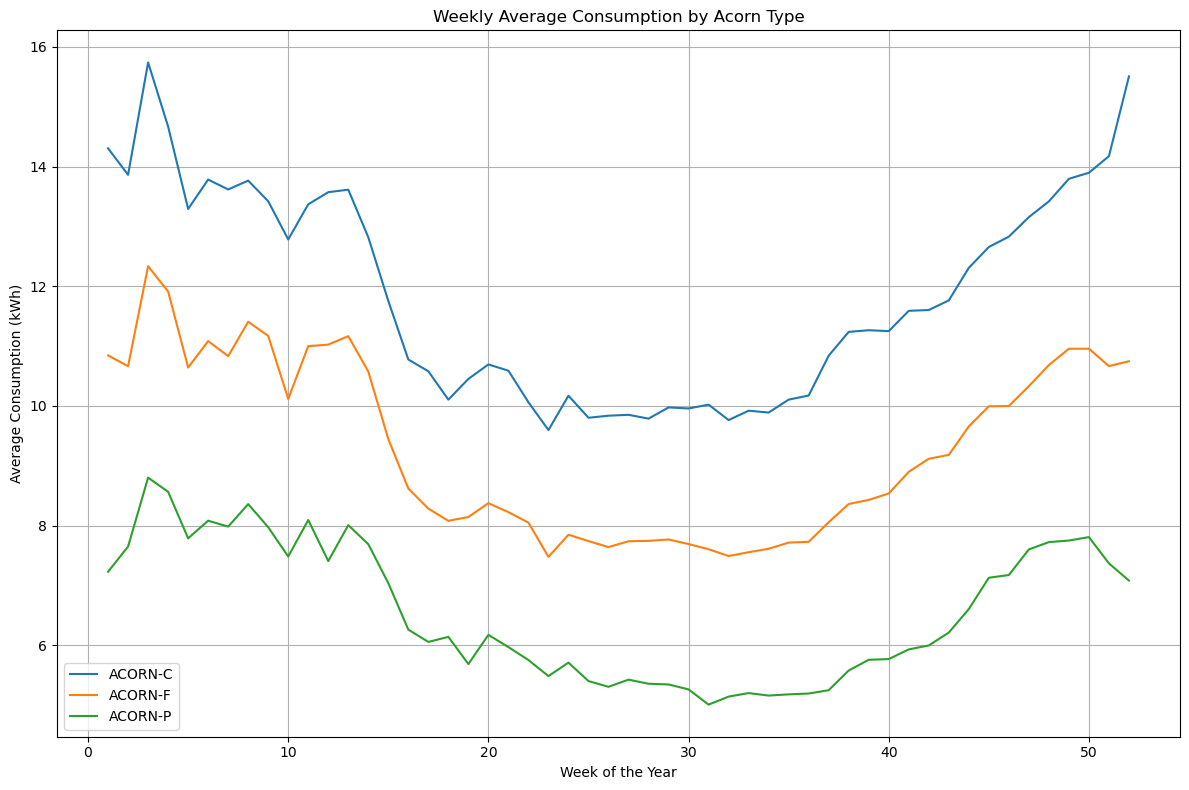

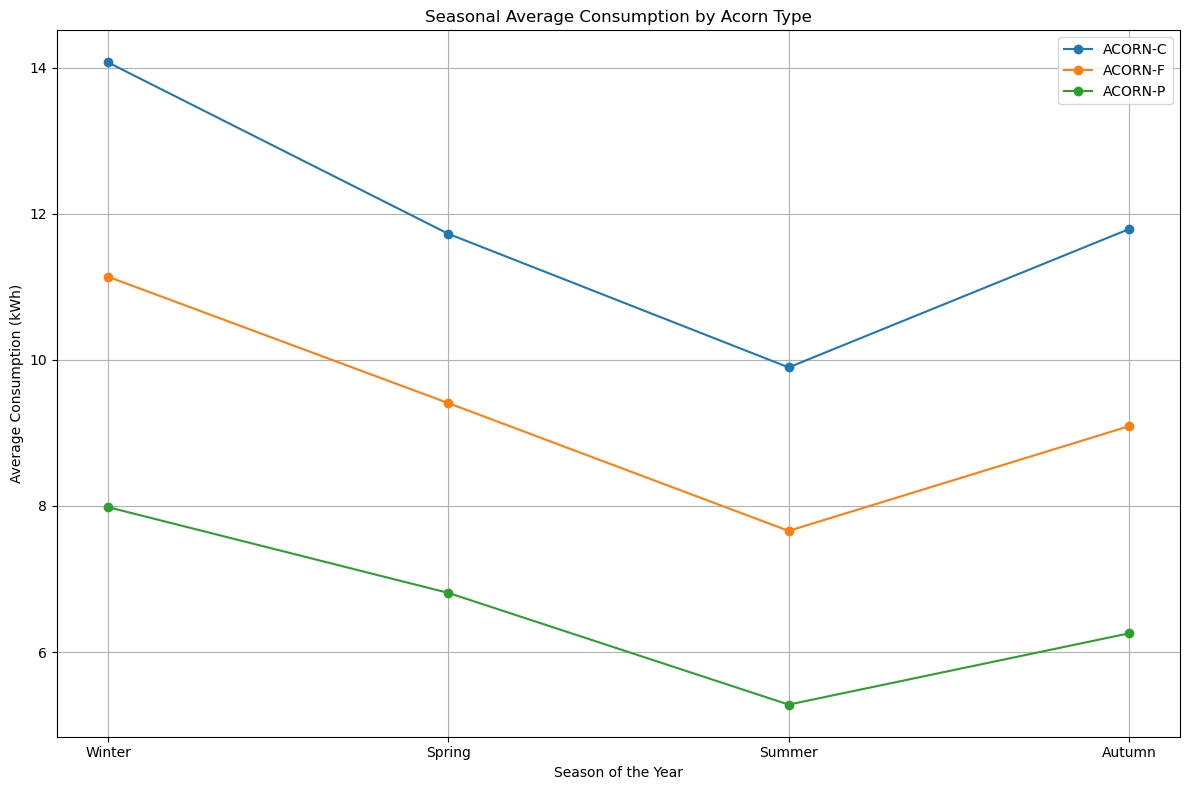

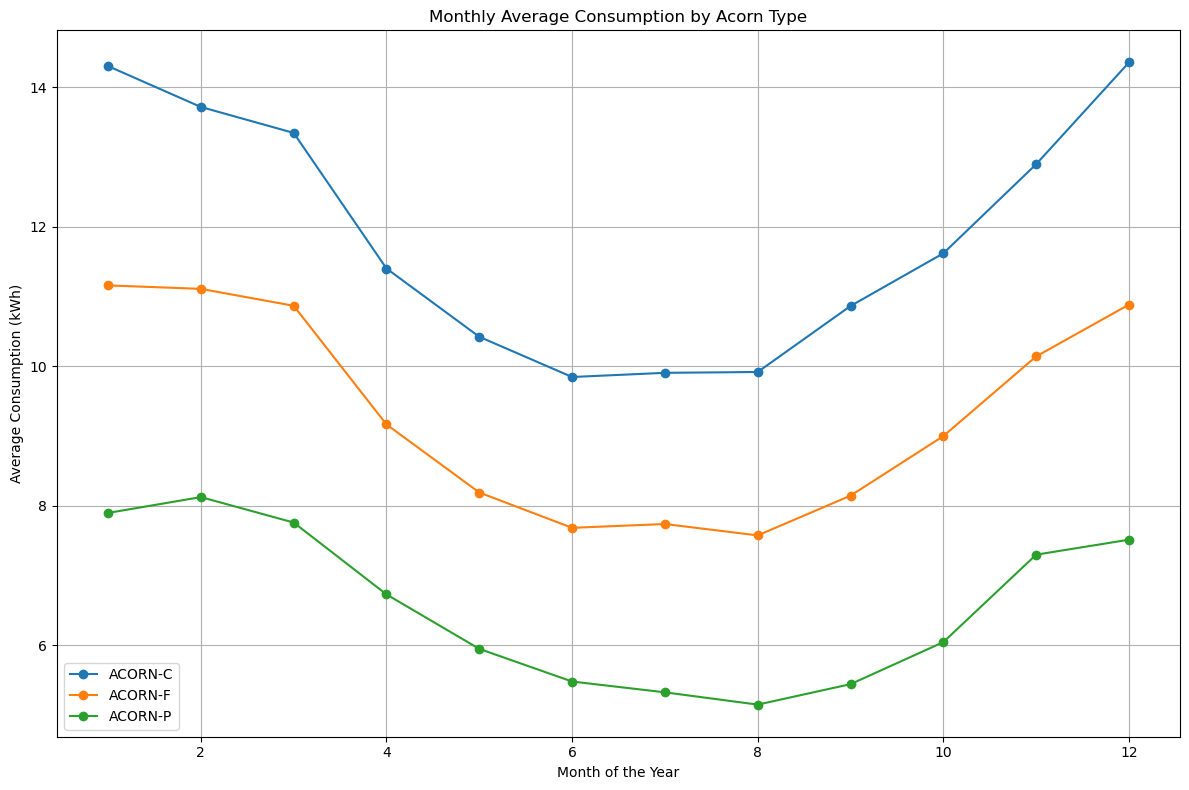

In [23]:
# Renaming data for easy access:
daily = group_4_daily.copy()
half_hourly = group_4_half_hourly.copy()

# Splitting the daily data per 'Acorn' type:
acorn_types = daily['Acorn'].unique()
acorn_data = {acorn: daily[daily['Acorn'] == acorn] for acorn in acorn_types}

# Obtaining the weekly average consumption for each Acorn type:
weekly_avg_consumption = {}
for acorn, data in acorn_data.items():
    data = data.copy()
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Week'] = data['Date'].dt.isocalendar().week
    weekly_avg = data.groupby('Week', as_index=False)['Conso_kWh'].mean().reset_index()
    weekly_avg_consumption[acorn] = weekly_avg

# Plotting the weekly average consumption for each Acorn type:
plt.figure(figsize=(12, 8))
for acorn, weekly_avg in weekly_avg_consumption.items():
    plt.plot(weekly_avg['Week'], weekly_avg['Conso_kWh'], label=acorn)
plt.title('Weekly Average Consumption by Acorn Type')
plt.xlabel('Week of the Year')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Obtaining the average consumption per season for each Acorn type:
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_avg_consumption = {}
for acorn, data in acorn_data.items():
    data = data.copy()
    data['Season'] = pd.cut(data['Date'].dt.month, bins=[0, 3, 6, 9, 12], 
                            labels=seasons, right=False)
    seasonal_avg = data.groupby('Season', as_index=False, observed=False)['Conso_kWh'].mean()
    seasonal_avg_consumption[acorn] = seasonal_avg

# Plotting the average consumption per season for each Acorn type:
plt.figure(figsize=(12, 8))
for acorn, seasonal_avg in seasonal_avg_consumption.items():
    plt.plot(seasonal_avg['Season'], seasonal_avg['Conso_kWh'], label=acorn, marker='o')
plt.title('Seasonal Average Consumption by Acorn Type')
plt.xlabel('Season of the Year')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Obtaining the average consumption per month for each Acorn type:
monthly_avg_comnsumption = {}
for acorn, data in acorn_data.items():
    data = data.copy()
    data['Month'] = data['Date'].dt.month
    monthly_avg = data.groupby('Month', as_index=False)['Conso_kWh'].mean()
    monthly_avg_comnsumption[acorn] = monthly_avg
    
# Plotting the average consumption per month for each Acorn type:
plt.figure(figsize=(12, 8))
for acorn, monthly_avg in monthly_avg_comnsumption.items():
    plt.plot(monthly_avg['Month'], monthly_avg['Conso_kWh'], label=acorn, marker='o')
plt.title('Monthly Average Consumption by Acorn Type')
plt.xlabel('Month of the Year')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

